# Open Pose 사용 코드 템플릿

https://github.com/ForgottenOneNyx/Open-Pose-Keras 의 코드를 사용하여 포즈를 추출한다.

프로젝트 내의 demo.ipynb를 기반으로 하였다.

# 프로젝트 다운로드

In [ ]:
!git clone https://github.com/ForgottenOneNyx/Open-Pose-Keras

Cloning into 'Open-Pose-Keras'...
remote: Enumerating objects: 397, done.
remote: Total 397 (delta 0), reused 0 (delta 0), pack-reused 397
Receiving objects: 100% (397/397), 29.69 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [ ]:
%cd Open-Pose-Keras

/content/Open-Pose-Keras


# 필요한 라이브러리 설치

In [ ]:
!pip install configobj

  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34546 sha256=e63c6f936c5332477342a04872b884aca010aee762d58f0e17501ab7d56cae0e
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


# 모델 파일 다운로드

크기가 200M로, 구글 드라이브에 올려두었다.

이를 다운로드 하기 위해 gdown을 설치하고, 다운로드 받는다.

원 파일은 프로젝트에 다음의 링크에 있었다.

https://www.dropbox.com/s/llpxd14is7gyj0z/model.h5

In [ ]:
!pip install gdown

In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?id=1d9HGnnLhq6IhC5ZSVpBf7bSrpjNj5kPB', "model.h5", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1d9HGnnLhq6IhC5ZSVpBf7bSrpjNj5kPB
To: /content/Open-Pose-Keras/model.h5
100%|██████████| 210M/210M [00:00<00:00, 250MB/s]


'model.h5'

# 대상 이미지 준비

In [ ]:
!wget -O yuna.jpg https://cphoto.asiae.co.kr/listimglink/6/2013062219390479592_1.jpg

--2022-01-06 04:35:58--  https://cphoto.asiae.co.kr/listimglink/6/2013062219390479592_1.jpg
Resolving cphoto.asiae.co.kr (cphoto.asiae.co.kr)... 180.182.59.54
Connecting to cphoto.asiae.co.kr (cphoto.asiae.co.kr)|180.182.59.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘yuna.jpg’

yuna.jpg                [          <=>       ] 318.38K   132KB/s    in 2.4s    

2022-01-06 04:36:03 (132 KB/s) - ‘yuna.jpg’ saved [326022]



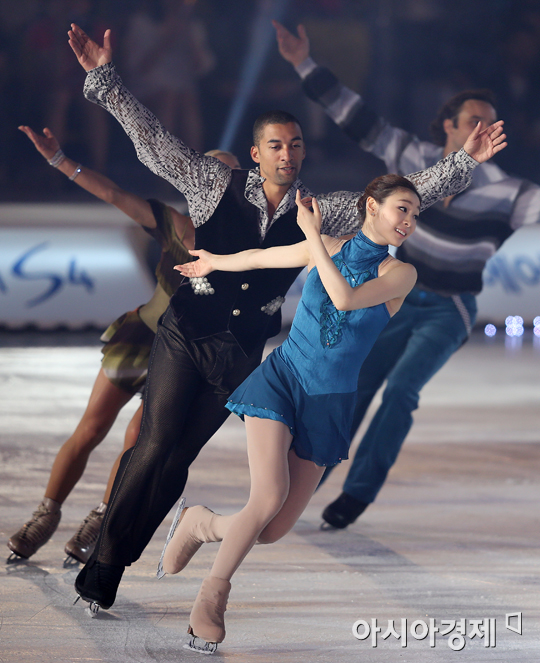

In [ ]:
from IPython.display import Image, display
display(Image('yuna.jpg'))

# 필요 함수 선언

In [ ]:
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util
from scipy.ndimage.filters import gaussian_filter

import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Activation, Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from config_reader import config_reader
import scipy
import math

In [ ]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

def load_model(weights_path):
    input_shape = (None,None,3)

    img_input = Input(shape=input_shape)

    stages = 6
    np_branch1 = 38
    np_branch2 = 19

    img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

    # VGG
    stage0_out = vgg_block(img_normalized)

    # stage 1
    stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
    stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
    x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

    # stage t >= 2
    for sn in range(2, stages + 1):
        stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
        stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
        if (sn < stages):
            x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

    model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
    model.load_weights(weights_path)

    return model


In [ ]:
SHOW_PROCESS = False

# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
          [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
          [1,16], [16,18], [3,17], [6,18]]


def extract(model, file_name):

  oriImg = cv2.imread(file_name) # B,G,R order

  param, model_params = config_reader()

  multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]


  heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
  paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
  if SHOW_PROCESS:
    # first figure shows padded images
    f, axarr = plt.subplots(1, len(multiplier))
    f.set_size_inches((20, 5))
    # second figure shows heatmaps
    f2, axarr2 = plt.subplots(1, len(multiplier))
    f2.set_size_inches((20, 5))
    # third figure shows PAFs
    f3, axarr3 = plt.subplots(2, len(multiplier))
    f3.set_size_inches((20, 10))

  for m in range(len(multiplier)):
      scale = multiplier[m]
      imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
      imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        

      if SHOW_PROCESS:
        axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
        axarr[m].set_title('Input image: scale %d' % m)

      input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
      # print("Input shape: " + str(input_img.shape))  

      output_blobs = model.predict(input_img)
      # print("Output shape (heatmap): " + str(output_blobs[1].shape))
      
      # extract outputs, resize, and remove padding
      heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
      heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
      heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
      heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
      
      paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
      paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
      paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
      paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
      
      if SHOW_PROCESS:
        # visualization
        axarr2[m].imshow(oriImg[:,:,[2,1,0]])
        ax2 = axarr2[m].imshow(heatmap[:,:,3], alpha=.5) # right elbow
        axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
        
        axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
        ax3x = axarr3.flat[m].imshow(paf[:,:,16], alpha=.5) # right elbow
        axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
        axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
        ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,17], alpha=.5) # right wrist
        axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
      
      heatmap_avg = heatmap_avg + heatmap / len(multiplier)
      paf_avg = paf_avg + paf / len(multiplier)

  # f2.subplots_adjust(right=0.93)
  # cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
  # _ = f2.colorbar(ax2, cax=cbar_ax)

  # f3.subplots_adjust(right=0.93)
  # cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
  # _ = f3.colorbar(ax3x, cax=cbar_axx)
  # cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
  # _ = f3.colorbar(ax3y, cax=cbar_axy)


  all_peaks = []
  peak_counter = 0

  for part in range(19-1):
      map_ori = heatmap_avg[:,:,part]
      map = gaussian_filter(map_ori, sigma=3)
      
      map_left = np.zeros(map.shape)
      map_left[1:,:] = map[:-1,:]
      map_right = np.zeros(map.shape)
      map_right[:-1,:] = map[1:,:]
      map_up = np.zeros(map.shape)
      map_up[:,1:] = map[:,:-1]
      map_down = np.zeros(map.shape)
      map_down[:,:-1] = map[:,1:]
      
      peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
      peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
      peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
      id = range(peak_counter, peak_counter + len(peaks))
      peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

      all_peaks.append(peaks_with_score_and_id)
      peak_counter += len(peaks)

  # the middle joints heatmap correpondence
  mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
            [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
            [55,56], [37,38], [45,46]]

  connection_all = []
  special_k = []
  mid_num = 10

  for k in range(len(mapIdx)):
      score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
      candA = all_peaks[limbSeq[k][0]-1]
      candB = all_peaks[limbSeq[k][1]-1]
      nA = len(candA)
      nB = len(candB)
      indexA, indexB = limbSeq[k]
      if(nA != 0 and nB != 0):
          connection_candidate = []
          for i in range(nA):
              for j in range(nB):
                  vec = np.subtract(candB[j][:2], candA[i][:2])
                  norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                  # failure case when 2 body parts overlaps
                  if norm == 0:
                      continue
                  vec = np.divide(vec, norm)
                  
                  startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                  
                  vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                    for I in range(len(startend))])
                  vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                    for I in range(len(startend))])

                  score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                  score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                  criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                  criterion2 = score_with_dist_prior > 0
                  if criterion1 and criterion2:
                      connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

          connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
          connection = np.zeros((0,5))
          for c in range(len(connection_candidate)):
              i,j,s = connection_candidate[c][0:3]
              if(i not in connection[:,3] and j not in connection[:,4]):
                  connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                  if(len(connection) >= min(nA, nB)):
                      break

          connection_all.append(connection)
      else:
          special_k.append(k)
          connection_all.append([])

  # last number in each row is the total parts number of that person
  # the second last number in each row is the score of the overall configuration
  subset = -1 * np.ones((0, 20))
  candidate = np.array([item for sublist in all_peaks for item in sublist])

  for k in range(len(mapIdx)):
      if k not in special_k:
          partAs = connection_all[k][:,0]
          partBs = connection_all[k][:,1]
          indexA, indexB = np.array(limbSeq[k]) - 1

          for i in range(len(connection_all[k])): #= 1:size(temp,1)
              found = 0
              subset_idx = [-1, -1]
              for j in range(len(subset)): #1:size(subset,1):
                  if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                      subset_idx[found] = j
                      found += 1
              
              if found == 1:
                  j = subset_idx[0]
                  if(subset[j][indexB] != partBs[i]):
                      subset[j][indexB] = partBs[i]
                      subset[j][-1] += 1
                      subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
              elif found == 2: # if found 2 and disjoint, merge them
                  j1, j2 = subset_idx
                  print ("found = 2")
                  membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                  if len(np.nonzero(membership == 2)[0]) == 0: #merge
                      subset[j1][:-2] += (subset[j2][:-2] + 1)
                      subset[j1][-2:] += subset[j2][-2:]
                      subset[j1][-2] += connection_all[k][i][2]
                      subset = np.delete(subset, j2, 0)
                  else: # as like found == 1
                      subset[j1][indexB] = partBs[i]
                      subset[j1][-1] += 1
                      subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

              # if find no partA in the subset, create a new subset
              elif not found and k < 17:
                  row = -1 * np.ones(20)
                  row[indexA] = partAs[i]
                  row[indexB] = partBs[i]
                  row[-1] = 2
                  row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                  subset = np.vstack([subset, row])

  # delete some rows of subset which has few parts occur
  deleteIdx = [];
  for i in range(len(subset)):
      if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
          deleteIdx.append(i)
  subset = np.delete(subset, deleteIdx, axis=0)


  return all_peaks, subset, candidate



In [ ]:
def draw_result(test_image, all_peaks, subset, candidate, draw_dot=True, draw_line=True):

  # visualize
  colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
            [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
            [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
  cmap = matplotlib.cm.get_cmap('hsv')

  canvas = cv2.imread(test_image) # B,G,R order

  if draw_dot:
    cur_canvas = canvas.copy()
    for i in range(18):
        rgba = np.array(cmap(1 - i/18. - 1./36))
        rgba[0:3] *= 255
        for j in range(len(all_peaks[i])):
            cv2.circle(cur_canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

    canvas = cv2.addWeighted(canvas, 0.3, cur_canvas, 0.7, 0)
    plt.imshow(canvas[:,:,[2,1,0]])

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 12)

  if draw_line:
    stickwidth = 4

    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i])-1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

  plt.imshow(canvas[:,:,[2,1,0]])
  fig = matplotlib.pyplot.gcf()
  fig.set_size_inches(12, 12)


# 포즈 추출 실행

In [ ]:
file_name = "yuna.jpg"
weights_path = "model.h5"

model = load_model(weights_path)

all_peaks, subset, candidate = extract(model, file_name)


found = 2


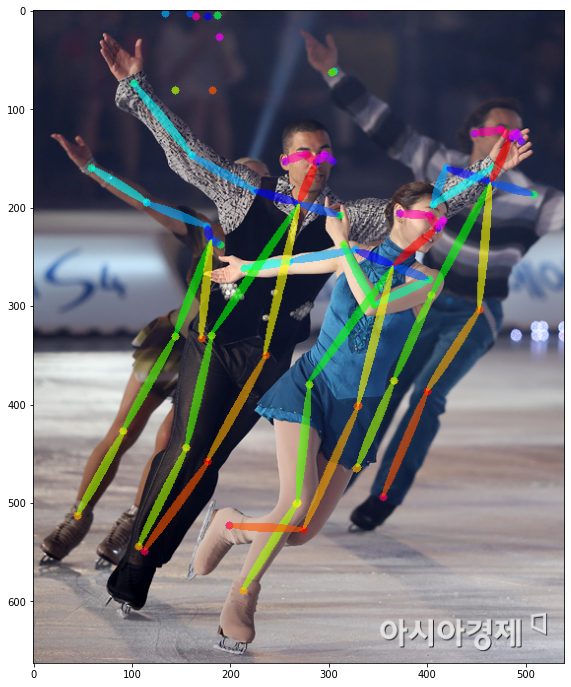

In [ ]:
draw_result(file_name, all_peaks, subset, candidate, draw_dot=True, draw_line=True)

# 다른 이미지 준비

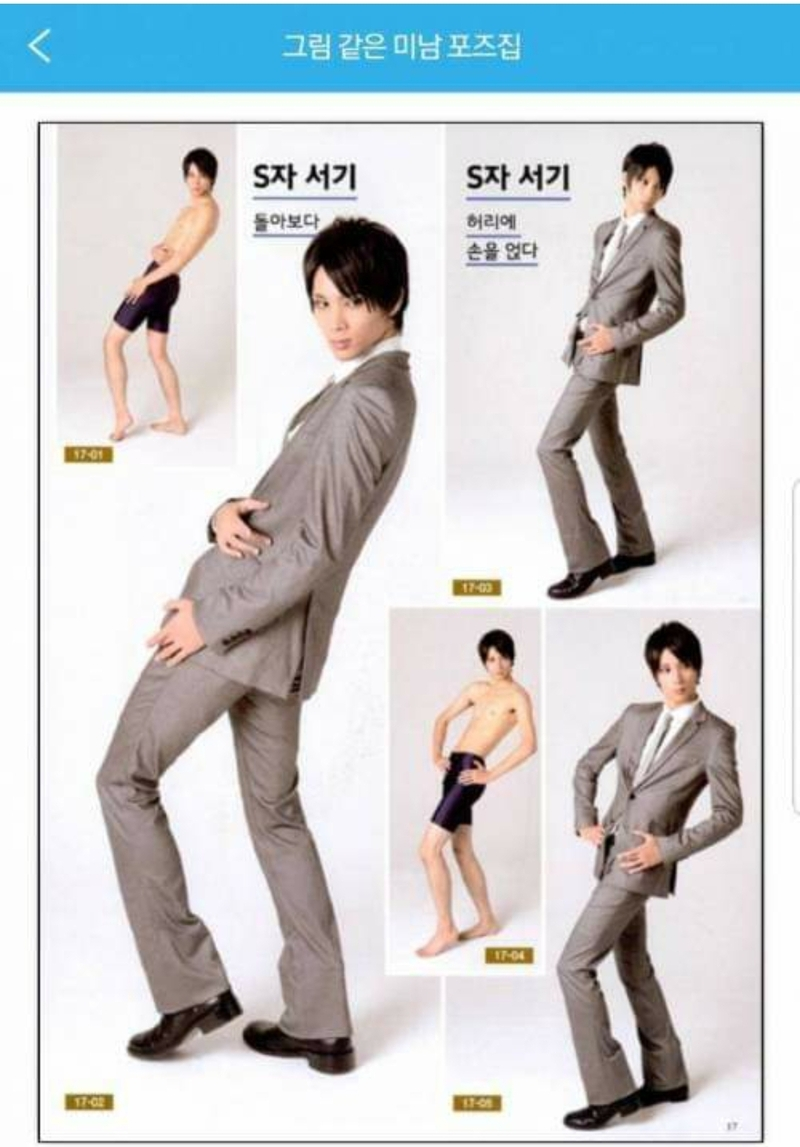

In [ ]:
from IPython.display import Image, display
display(Image('posee.jpeg'))

# 포즈 추출 실행

In [ ]:
file_name = "posee.jpeg"
weights_path = "model.h5"

model = load_model(weights_path)

all_peaks, subset, candidate = extract(model, file_name)


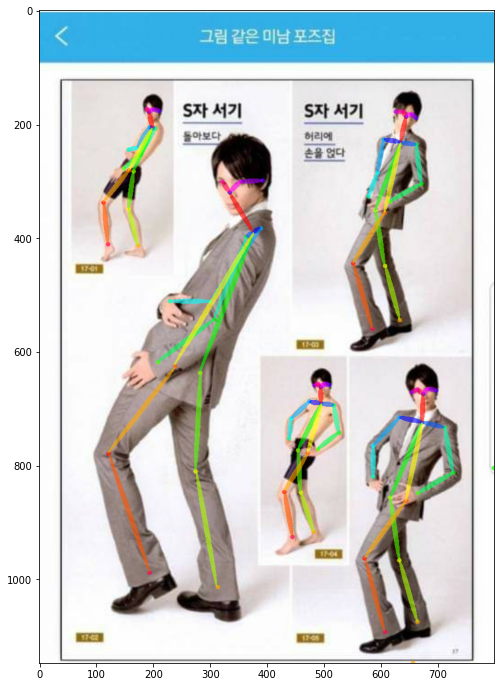

In [ ]:
draw_result(file_name, all_peaks, subset, candidate, draw_dot=True, draw_line=True)

# 추출 결과 해석

all_peak와 subset에 그 결과가 담긴다.

- all_peaks : 추출된 모든 포인트의 정보
- subset : 사람 별로 추출된 포인트의 정보

18개 부위를 추출한다.

각 부위의 이름은 config.py에 정의되어 있다.

```
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]
```

## all_peaks

추출된 점이 담긴 all_peaks는 18개의 요소가 있는 리스트이다.

In [ ]:
print(len(all_peaks))

18


In [ ]:
_, model_params = config_reader()
part_str = model_params['part_str']
for i in range(18):
  print(part_str[i], ": ", all_peaks[i])

[nose :  [(177, 6, 0.11634603881975636, 0), (484, 130, 0.7376981675624847, 1), (287, 154, 0.9168481826782227, 2), (410, 221, 0.9359188973903656, 3)]
neck :  [(159, 3, 0.15268721574830124, 4), (463, 174, 0.6495651453733444, 5), (464, 175, 0.6481998227536678, 6), (269, 196, 0.8361004292964935, 7), (180, 233, 0.13341300701722503, 8), (365, 259, 0.8730712682008743, 9)]
Rsho :  [(134, 3, 0.13538085088111984, 10), (419, 160, 0.5524027124047279, 11), (224, 183, 0.6817551255226135, 12), (176, 219, 0.20693255960941315, 13), (327, 243, 0.7500508278608322, 14)]
Relb :  [(161, 147, 0.4612097293138504, 15), (115, 195, 0.6741258054971695, 16), (406, 197, 0.17111701145768166, 17), (260, 255, 0.5720157846808434, 18)]
Rwri :  [(305, 62, 0.17255936190485954, 19), (102, 74, 0.657935693860054, 20), (467, 159, 0.5370954032987356, 21), (59, 160, 0.7744938731193542, 22), (214, 262, 0.7678695023059845, 23)]
Lsho :  [(187, 5, 0.11818076443159953, 24), (508, 187, 0.5617954544723034, 25), (311, 208, 0.6824826002

all_peaks[0]은 추출된 nose의 포인트가 담겨 있다.

In [ ]:
for i in range(len(all_peaks[0])):
  print(all_peaks[0][i])

(177, 6, 0.11634603881975636, 0)
(484, 130, 0.7376981675624847, 1)
(287, 154, 0.9168481826782227, 2)
(410, 221, 0.9359188973903656, 3)



1개의 point는 다음과 같이 구성된다.
```
(484, 130, 0.7376982569694519, 1)
  x    y   score               point_id
```

## subset

subset 각 요소는 사람 1명에 대한 추출 결과이다.

In [ ]:
print(len(subset))

5


1개의 subset 요소는 1사람에 대한 19개 포인트 id로 구성되어 있다.

In [ ]:
print(subset[0])

[ 3.          9.         14.         18.         23.         28.
 29.         31.         37.         41.         47.         52.
 56.         58.         63.         67.         70.         -1.
 26.11571592 17.        ]



point_id는 all_peaks에 명시되어 있다.
```
all_peaks의 내용

(177, 6, 0.11634597013471648, 0)
(484, 130, 0.7376982569694519, 1)
(287, 154, 0.9168482273817062, 2)
(410, 221, 0.9359188675880432, 3)

각 줄의 마지막 숫가가 point_id이다.

```

각 포인트별 연결 가능 여부는 limSeq에 담겨 있다.

In [ ]:
print(len(limbSeq))
print(limbSeq)

19
[[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], [1, 16], [16, 18], [3, 17], [6, 18]]


[2, 3] 은 neck과 Rsho(righst shoulder)가 연결되어 있음을 의미하고, 

[3,4]는 Rsho(righst shoulder)와 Relb(right elbow)가 이어져 있다는 것을 의미한다.

```
1: nose
2: neck
3: Rsho
4: Relb
5: Rwri
...
```


In [ ]:
!wget -O posee.jpeg https://cdn.imweb.me/upload/S202002259d2c4f16c33cd/8c7916630bd72.jpeg

--2022-01-06 04:42:09--  https://cdn.imweb.me/upload/S202002259d2c4f16c33cd/8c7916630bd72.jpeg
Resolving cdn.imweb.me (cdn.imweb.me)... 18.66.248.51, 18.66.248.66, 18.66.248.111, ...
Connecting to cdn.imweb.me (cdn.imweb.me)|18.66.248.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338406 (330K) [image/jpeg]
Saving to: ‘posee.jpeg’

posee.jpeg          100%[===================>] 330.47K   352KB/s    in 0.9s    

2022-01-06 04:42:11 (352 KB/s) - ‘posee.jpeg’ saved [338406/338406]

